<a href="https://www.kaggle.com/code/fariskarim/eda-fe-and-predictions?scriptVersionId=139946801" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salaly-prediction-for-beginer/Salary Data.csv


In [2]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import statistics
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
salary_data = pd.read_csv('/kaggle/input/salaly-prediction-for-beginer/Salary Data.csv')

In [4]:
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [5]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [6]:
salary_data['Job Title'].unique

<bound method Series.unique of 0                  Software Engineer
1                       Data Analyst
2                     Senior Manager
3                    Sales Associate
4                           Director
                   ...              
370         Senior Marketing Analyst
371           Director of Operations
372           Junior Project Manager
373    Senior Operations Coordinator
374          Senior Business Analyst
Name: Job Title, Length: 375, dtype: object>

In [7]:
salary_data.describe()

,Age,Years of Experience,Salary
count,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845
std,7.069073,6.557007,48240.013482
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


In [8]:
salary_data_cleaned = salary_data.dropna()

salary_data_cleaned.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [9]:
salary_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 20.4+ KB


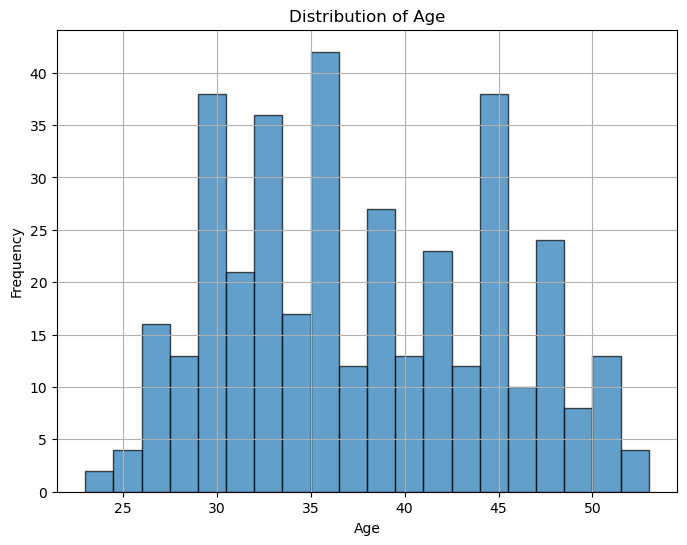

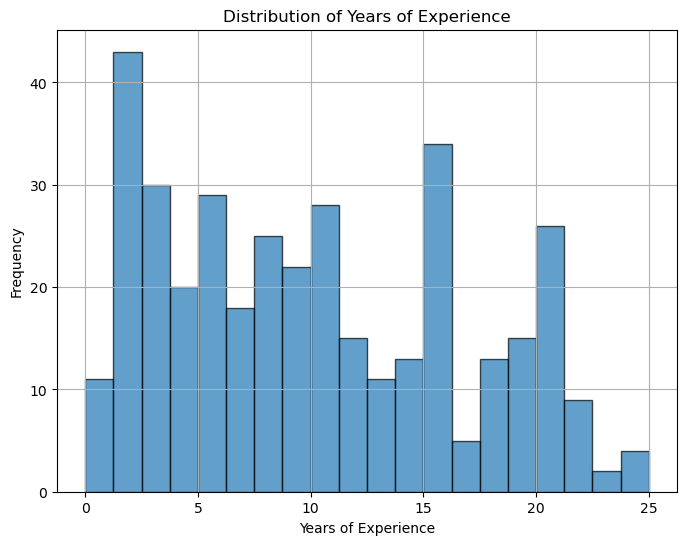

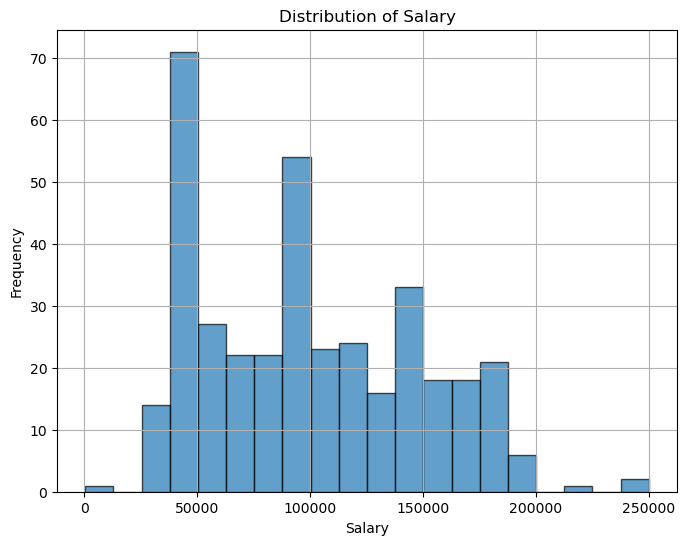

In [10]:
numeric_cols = salary_data.select_dtypes(include=[np.number]).columns

for column in numeric_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(salary_data_cleaned[column], bins=20, edgecolor='k', alpha=0.7,)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Feature engineering

In [11]:
def determine_role(row):
    if row['Years of Experience'] < 5:
        return 0
    elif 'CEO' in row['Job Title'] or 'Chief' in row['Job Title'] or 'Director' in row['Job Title'] or (row['Years of Experience'] > 20):
        return 2
    elif 'VP' in row['Job Title'] or 'Senior' in row['Job Title'] or 'Engineer' in row['Job Title'] or 'Manager' in row['Job Title']:
        return 1
    else:
        return 0

salary_data_cleaned['Senior_or_Director'] = salary_data_cleaned.apply(determine_role, axis=1)

/tmp/ipykernel_21/1298468236.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_data_cleaned['Senior_or_Director'] = salary_data_cleaned.apply(determine_role, axis=1)


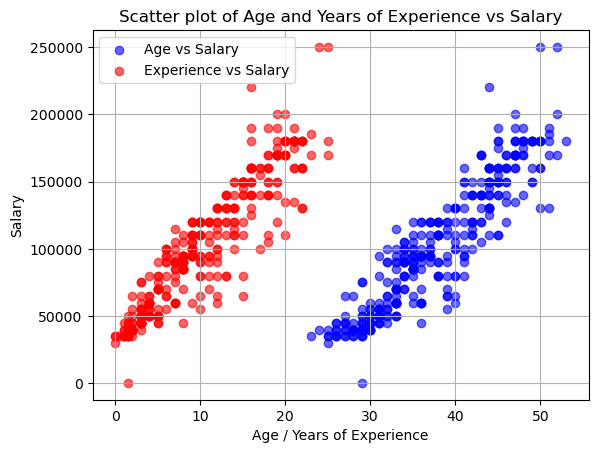

In [12]:

plt.scatter(salary_data_cleaned['Age'], salary_data_cleaned['Salary'], color='blue', label='Age vs Salary', alpha=0.6)

plt.scatter(salary_data_cleaned['Years of Experience'], salary_data_cleaned['Salary'], color='red', label='Experience vs Salary', alpha=0.6)

plt.xlabel('Age / Years of Experience')
plt.ylabel('Salary')
plt.title('Scatter plot of Age and Years of Experience vs Salary')
plt.legend()
plt.grid(True)
plt.show()

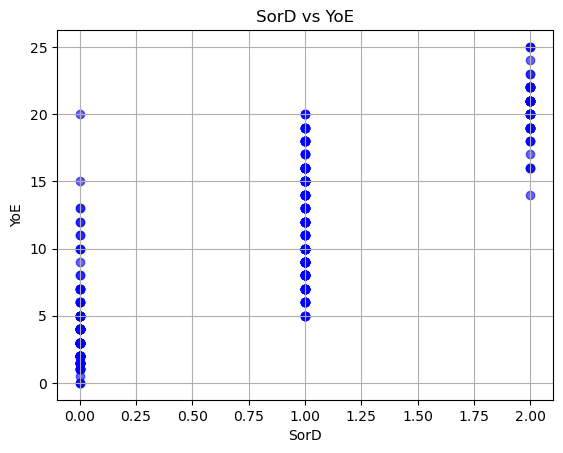

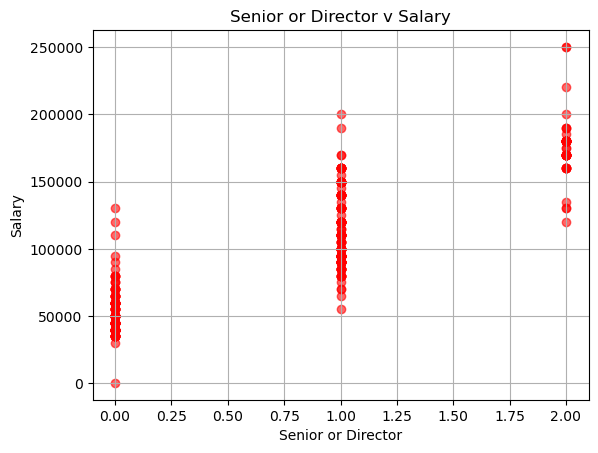

In [13]:
plt.figure()
plt.scatter(salary_data_cleaned['Senior_or_Director'], salary_data_cleaned['Years of Experience'], color='blue', alpha=0.6)
plt.xlabel('SorD')
plt.ylabel('YoE')
plt.title('SorD vs YoE')
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(salary_data_cleaned['Senior_or_Director'], salary_data_cleaned['Salary'], color='red', alpha=0.6)
plt.xlabel('Senior or Director')
plt.ylabel('Salary')
plt.title('Senior or Director v Salary')
plt.grid(True)
plt.show()

In [14]:
filtered_rows = salary_data_cleaned[(salary_data_cleaned['Salary'] < 150000) & 
                                    (salary_data_cleaned['Senior_or_Director'] == 2)]
filtered_rows

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Senior_or_Director
50,51.0,Female,Bachelor's,Customer Service Manager,22.0,130000.0,2
74,42.0,Female,Master's,Creative Director,14.0,120000.0,2
88,46.0,Male,Master's,Senior Project Manager,21.0,135000.0,2
112,50.0,Female,Bachelor's,Supply Chain Analyst,22.0,130000.0,2


In [15]:
corr_matrix = salary_data.corr()

/tmp/ipykernel_21/2345637380.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = salary_data.corr()


In [16]:
corr_matrix['Salary'].sort_values(ascending=False)

Salary                 1.000000
Years of Experience    0.930338
Age                    0.922335
Name: Salary, dtype: float64

In [17]:
salary_data_cleaned['Education Level'].value_counts()

Bachelor's    224
Master's       98
PhD            51
Name: Education Level, dtype: int64

In [18]:

label_encoder = LabelEncoder()

salary_data_cleaned['EncodedEducation'] = label_encoder.fit_transform(salary_data_cleaned['Education Level'])


salary_data_cleaned.head()

/tmp/ipykernel_21/798904781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_data_cleaned['EncodedEducation'] = label_encoder.fit_transform(salary_data_cleaned['Education Level'])


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Senior_or_Director,EncodedEducation
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,1,0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,0,1
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,1,2
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,0,0
4,52.0,Male,Master's,Director,20.0,200000.0,2,1


In [19]:
salary_data_cleaned['Job Title'].value_counts()

Director of Marketing              12
Director of Operations             11
Senior Business Analyst            10
Senior Marketing Analyst            9
Senior Marketing Manager            9
                                   ..
Business Development Manager        1
Customer Service Representative     1
IT Manager                          1
Digital Marketing Manager           1
Junior Web Developer                1
Name: Job Title, Length: 174, dtype: int64

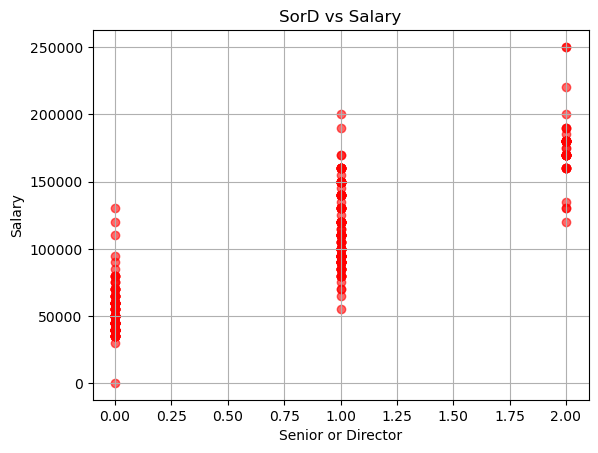

In [20]:
plt.figure()
plt.scatter(salary_data_cleaned['Senior_or_Director'], salary_data_cleaned['Salary'], color='red', alpha=0.6)
plt.xlabel('Senior or Director')
plt.ylabel('Salary')
plt.title('SorD vs Salary')
plt.grid(True)
plt.show()

In [21]:
salary_data_cleaned.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Senior_or_Director,EncodedEducation
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,1,0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,0,1
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,1,2
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,0,0
4,52.0,Male,Master's,Director,20.0,200000.0,2,1


In [22]:
salary_data_cleaned = pd.get_dummies(salary_data_cleaned, columns=['Gender'])

In [23]:
salary_data_cleaned.head()

,Age,Education Level,Job Title,Years of Experience,Salary,Senior_or_Director,EncodedEducation,Gender_Female,Gender_Male
0,32.0,Bachelor's,Software Engineer,5.0,90000.0,1,0,0,1
1,28.0,Master's,Data Analyst,3.0,65000.0,0,1,1,0
2,45.0,PhD,Senior Manager,15.0,150000.0,1,2,0,1
3,36.0,Bachelor's,Sales Associate,7.0,60000.0,0,0,1,0
4,52.0,Master's,Director,20.0,200000.0,2,1,0,1


In [24]:
corr_matrix = salary_data_cleaned.corr()

/tmp/ipykernel_21/358347868.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = salary_data_cleaned.corr()


In [25]:
corr_matrix['Salary'].sort_values(ascending=False)

Salary                 1.000000
Years of Experience    0.930338
Age                    0.922335
Senior_or_Director     0.879400
EncodedEducation       0.670371
Gender_Male            0.071106
Gender_Female         -0.071106
Name: Salary, dtype: float64

In [26]:
from sklearn.model_selection import train_test_split


X = salary_data_cleaned[['Years of Experience','Age','EncodedEducation','Gender_Male','Senior_or_Director',]]
y = salary_data_cleaned['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (298, 5)
X_test shape: (75, 5)
y_train shape: (298,)
y_test shape: (75,)


### Linear Regression

In [27]:

linear_model = LinearRegression()

mse_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE scores
rmse_scores = np.sqrt(-mse_scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE score:", rmse_scores.mean())


RMSE scores for each fold: [11541.48185712 13856.86440484 12509.57198221 11887.11834498
 10340.06071536]
Mean RMSE score: 12027.01946090252


Trying a square root transformation on the target variable

In [28]:
y_sqrt = np.sqrt(y)

def five_iters(X, y):
    errors = []
    for i in range(5):
        X_train_sqrt, X_test_sqrt, y_train_sqrt, y_test_sqrt = train_test_split(X, y_sqrt, test_size= .2)
        reglog = LinearRegression()
        reglog.fit(X_train_sqrt, y_train_sqrt)

        y_pred_sqrt = reglog.predict(X_test_sqrt)

        y_pred = (y_pred_sqrt) ** 2
        rmse = np.sqrt(mean_squared_error(((y_test_sqrt) ** 2), y_pred))
        print("RMSE:", rmse)
        errors.append(rmse)
    print('Mean RMSE:', statistics.mean(errors))
        


five_iters(X,y_sqrt)

RMSE: 14339.607526226546
RMSE: 12237.841049036242
RMSE: 13923.246479125235
RMSE: 12782.776239195344
RMSE: 17654.80367705166
Mean RMSE: 14187.654994127006


In [29]:
reg = LinearRegression().fit(X_train, y_train)

perm = PermutationImportance(reg).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.4199 ± 0.0839,Age
0.2281 ± 0.0358,Senior_or_Director
0.0986 ± 0.0151,EncodedEducation
0.0130 ± 0.0054,Years of Experience
0.0119 ± 0.0039,Gender_Male


### Random Forest

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators_values = [500]

best_rmse = float('inf') 
best_n_estimators = None

for n_estimators in n_estimators_values:

    model = RandomForestRegressor(n_estimators=n_estimators)
    
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    

    mean_rmse = rmse_scores.mean()
    
    print(f"Number of estimators: {n_estimators}, Mean RMSE: {mean_rmse}")
    
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_n_estimators = n_estimators

print("Best RMSE:", best_rmse)
print("Best number of estimators:", best_n_estimators)






Number of estimators: 500, Mean RMSE: 14288.852304224696
Best RMSE: 14288.852304224696
Best number of estimators: 500


### Lasso

In [31]:


alpha_values = [0.01, 0.1]

best_rmse = float('inf')  
best_alpha = None

for alpha in alpha_values:
    print(f"Alpha: {alpha}")
    
    model = Lasso(alpha=alpha)
    
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    mean_rmse = rmse_scores.mean()
    
    print("Cross-validation RMSE scores:", rmse_scores)
    print("Mean RMSE:", mean_rmse)

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_alpha = alpha

print("Best RMSE:", best_rmse)
print("Best alpha:", best_alpha)


Alpha: 0.01
Cross-validation RMSE scores: [13331.8688248  10395.53396093 14238.47387941 15069.08177064
 12285.69147059]
Mean RMSE: 13064.129981272705
Alpha: 0.1
Cross-validation RMSE scores: [13331.86582215 10395.54482174 14238.39610023 15069.15807997
 12285.66424844]
Mean RMSE: 13064.125814505027
Best RMSE: 13064.125814505027
Best alpha: 0.1


### Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

learning_rates = [ 0.1, 0.2]
n_estimators_values = [ 100, 150]

best_rmse = float('inf')  
best_learning_rate = None
best_n_estimators = None

for learning_rate in learning_rates:
    for n_estimators in n_estimators_values:
        print(f"Learning Rate: {learning_rate}, Number of Estimators: {n_estimators}")
        
        model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators)
        
        rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
        
        mean_rmse = rmse_scores.mean()
        
        print("Cross-validation RMSE scores:", rmse_scores)
        print("Mean RMSE:", mean_rmse)
        
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_learning_rate = learning_rate
            best_n_estimators = n_estimators

print("Best RMSE:", best_rmse)
print("Best learning rate:", best_learning_rate)
print("Best number of estimators:", best_n_estimators)


Learning Rate: 0.1, Number of Estimators: 100
Cross-validation RMSE scores: [14447.02549224 10904.06695754 14848.28203163 13947.81026786
 14726.32543061]
Mean RMSE: 13774.702035975826
Learning Rate: 0.1, Number of Estimators: 150
Cross-validation RMSE scores: [14558.58515761 11525.87709915 14833.4336414  13476.8963622
 15567.05032883]
Mean RMSE: 13992.36851783709
Learning Rate: 0.2, Number of Estimators: 100
Cross-validation RMSE scores: [14723.21437713 11325.42019122 13239.51272572 15639.9804429
 15663.46332349]
Mean RMSE: 14118.318212091055
Learning Rate: 0.2, Number of Estimators: 150
Cross-validation RMSE scores: [15086.05671954 11758.93163024 13324.16670069 14639.39749124
 17261.91780505]
Mean RMSE: 14414.094069352263
Best RMSE: 13774.702035975826
Best learning rate: 0.1
Best number of estimators: 100


### Ridge Regression

In [33]:
from sklearn.linear_model import Ridge

alpha_values = [0.01, 0.1, 1.0]
best_rmse = float('inf')
best_alpha = None

for alpha in alpha_values:
    model = Ridge(alpha=alpha)
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    mean_rmse = rmse_scores.mean()
    print("Alpha:", alpha)
    print("Cross-validation RMSE scores:", rmse_scores)
    print("Mean RMSE:", mean_rmse)
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_alpha = alpha

print("Best RMSE:", best_rmse)
print("Best alpha:", best_alpha)


Alpha: 0.01
Cross-validation RMSE scores: [13331.73778132 10395.61579796 14237.79637696 15069.81402123
 12285.31456103]
Mean RMSE: 13064.055707702255
Alpha: 0.1
Cross-validation RMSE scores: [13330.57707631 10396.39021528 14231.67689483 15076.47515018
 12281.98081975]
Mean RMSE: 13063.4200312699
Alpha: 1.0
Cross-validation RMSE scores: [13321.01516195 10406.68903861 14175.74492095 15142.52647676
 12256.63430232]
Mean RMSE: 13060.521980118938
Best RMSE: 13060.521980118938
Best alpha: 1.0


#### Using LinearRegression gives us the lowest RMSE. Now we perform a final prediction using all of the data.

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:     ", rmse)

RMSE:      13508.24349944359
